<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from typing import Tuple
import numpy as np
from torch.utils.data import Dataset, Subset
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

from torchvision import models
from tqdm.notebook import tqdm


from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ExponentialLR
from PIL import Image

In [2]:
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/flowerdata-module5.zip'
!unzip -qqo {path} -d ./

# split train/validation with stratification

In [5]:
path = '/content/train/train/'

files = []
for (dirpath, _, filenames) in os.walk(path):
  for f in filenames:
    if f.endswith('.jpg'):
      label = int(dirpath.split('/')[-1]) - 1
      files.append([dirpath+'/'+f, label, f,])
files = pd.DataFrame(files, columns = ['path','label','filename',])

files[['label']].value_counts()

label
50       206
76       205
45       157
88       153
72       147
        ... 
34        33
25        33
32        31
33        28
0         27
Length: 102, dtype: int64

In [6]:
train_files, val_files = train_test_split(files, test_size=0.25, stratify= files.label, random_state=13)

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transforms = transforms.Compose([\
                                              transforms.RandomRotation(45),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomVerticalFlip(),
                                              transforms.ToTensor()
                                       ])
val_transforms = transforms.Compose([
                                              transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor()
                                     ])

In [8]:
path_test = '/content/test/valid/'

files_test = []
for (dirpath, _, filenames) in os.walk(path_test):
  for f in filenames:
    if f.endswith('.jpg'):
      files_test.append([dirpath+'/'+f, f,])
files_test = pd.DataFrame(files_test, columns = ['path','filename',])

files_test.head()

,path,filename
0,/content/test/valid//image_06501.jpg,image_06501.jpg
1,/content/test/valid//image_05168.jpg,image_05168.jpg
2,/content/test/valid//image_00759.jpg,image_00759.jpg
3,/content/test/valid//image_06788.jpg,image_06788.jpg
4,/content/test/valid//image_05508.jpg,image_05508.jpg


In [9]:
class CustomDataset(Dataset):
    def __init__(self, files, transform, normalize = None):
        files = files.reset_index(drop = True)
        self.paths = files['path'].to_dict()
        self.labels = files['label'].to_dict()
        self.filenames = files['filename'].to_dict()
        self.transform = transform
        self.normalize = normalize
    def __len__(self):
        return len(self.paths)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        path = self.paths[idx]
        # print(path)
        label = self.labels[idx]
        label = torch.LongTensor([label]).squeeze() 
        file_name = self.filenames[idx]
        image = self.pil_loader(path)
        image = self.transform(image)
        if self.normalize:
            image = self.normalize(image)
        return image, file_name, label

In [10]:
batch_size = 16

train_dataset = CustomDataset(files = train_files, transform=train_transforms, )
val_dataset = CustomDataset(files = val_files, transform=val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

train_dataloader:


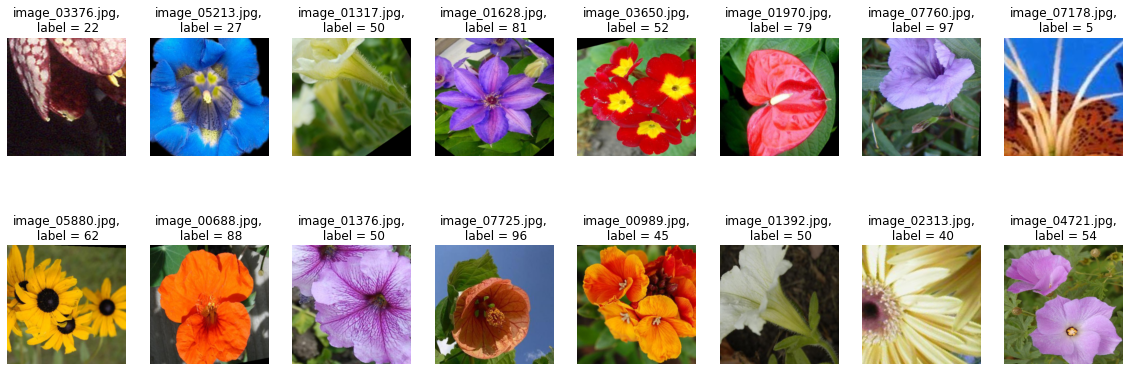

val_dataloader:


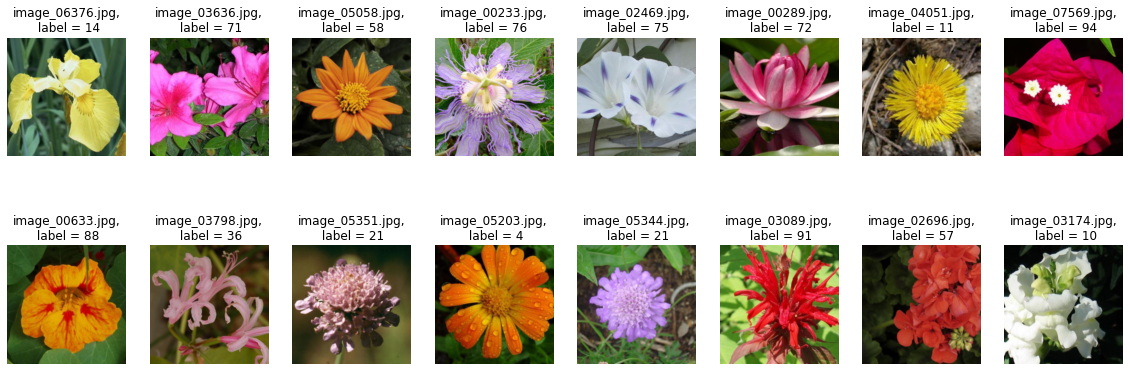

In [11]:
def plot_examples(image, file_name, label):
  figure = plt.figure(figsize=(20, 7))
  cols, rows = 8, 2
  for i in range(0, cols * rows):

    figure.add_subplot(rows, cols, i+1)

    plt.title(f'{file_name[i]},\n label = {label[i].item()}')
    plt.axis("off")
    plt.imshow(image[i].numpy().transpose([1,2,0]))
  plt.show()

print('train_dataloader:')
image, file_name, label = next(iter(train_dataloader))
plot_examples(image, file_name, label)
print('val_dataloader:')
image, file_name, label = next(iter(val_dataloader))
plot_examples(image, file_name, label)

In [12]:
batch_size = 32
train_dataset = CustomDataset(files = train_files, transform=train_transforms, normalize = normalize)
val_dataset = CustomDataset(files = val_files, transform=val_transforms, normalize = normalize)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
net = models.densenet161(pretrained=True)
net.classifier =  torch.nn.Linear(in_features=2208, out_features=102, bias=True)

requires_grads = [x > 7 for x in range(len(net.features))]
print(f'requires_grads: {requires_grads}')

for ind, flag in enumerate(requires_grads):
  for param in net.features[ind].parameters():
    param.requires_grad = flag

net = net.to(device)

requires_grads: [False, False, False, False, False, False, False, False, True, True, True, True]


In [72]:
checkpoint_path = '/content/drive/MyDrive/checkpoint.pth'

def save_checkpoint(model, optimizer, checkpoint_path, epoch, loss_train, f1_train, loss_valid, f1_valid):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss_train': loss_train,
        'f1_train': f1_train,
        'loss_valid': loss_valid,
        'f1_valid': f1_valid,
    }, checkpoint_path)

def load_checkpoint(model, optimizer, checkpoint_path, epoch, loss_train, f1_train, loss_valid, f1_valid):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss_train = checkpoint['loss_train']
    f1_train = checkpoint['f1_train']
    loss_valid = checkpoint['loss_valid']
    f1_valid = checkpoint['f1_valid']
    return model, optimizer, epoch, loss_train, f1_train, loss_valid, f1_valid

In [73]:
def train_model(net,
                optimizer,
                criterion,
                train_dataloader,
                val_dataloader,
                num_epochs):
  
    # check checkpoint
    try:
      net, optimizer, start_epoch, loss_train, f1_train, loss_valid, f1_valid = \
      load_checkpoint(neZ, optimizer, checkpoint_path, epoch, loss_train, f1_train, loss_valid, f1_valid)
    except:
      start_epoch = 0
  
    loss_train, loss_valid = [], []
    f1_train, f1_valid = [], []

    for epoch in range(start_epoch + 1, num_epochs + 1):
        print(f'epoch: {epoch} of {num_epochs}')
        torch.set_grad_enabled(True)
        net.train()
        losses, f1 = [], []
        print('TRAIN:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(train_dataloader)):
            # print(i, end =', ')
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            try:
              losses.append(loss.item())
            except:
              return losses, loss

            f1.append(f1_score(label.cpu().numpy(), output.argmax(1).cpu().numpy(), average='macro'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')
        loss_train.append(mean_losses)
        f1_train.append(mean_f1)
        torch.set_grad_enabled(False)
        net.eval()
        losses, f1 = [], []
        print('VALIDATION:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(val_dataloader)):
            # print(i, end =', ')
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            losses.append(loss.item())
            f1.append(f1_score(label.cpu().numpy(), output.argmax(1).cpu().numpy(), average='macro'))
        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')

        loss_valid.append(mean_losses)
        f1_valid.append(mean_f1)
        save_checkpoint(net, optimizer, checkpoint_path, epoch, loss_train, f1_train, loss_valid, f1_valid)

    return loss_train, f1_train, loss_valid, f1_valid

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [ ]:
loss_train, f1_train, loss_valid, f1_valid = train_model(net = net,
                                                         optimizer = optimizer,
                                                         criterion = criterion,
                                                         train_dataloader = train_dataloader,
                                                         val_dataloader = val_dataloader,
                                                         num_epochs = 50)

epoch: 1 of 50
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 1.1254030427375397, mean_f1: 0.5484511643491337
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.9289045012914218, mean_f1: 0.6482307919677195
epoch: 2 of 50
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.8217715531974644, mean_f1: 0.6469935577735477
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.5813655108213425, mean_f1: 0.7447694842610045
epoch: 3 of 50
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.694392324171283, mean_f1: 0.6958241604821358
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.423516836303931, mean_f1: 0.7769164533804911
epoch: 4 of 50
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.5802560695870356, mean_f1: 0.7292368630809716
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.4138817661800064, mean_f1: 0.804817414967191
epoch: 5 of 50
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.5147983211201507, mean_f1: 0.7610973325896131
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.35072593125872886, mean_f1: 0.8342342447636393
epoch: 6 of 50
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

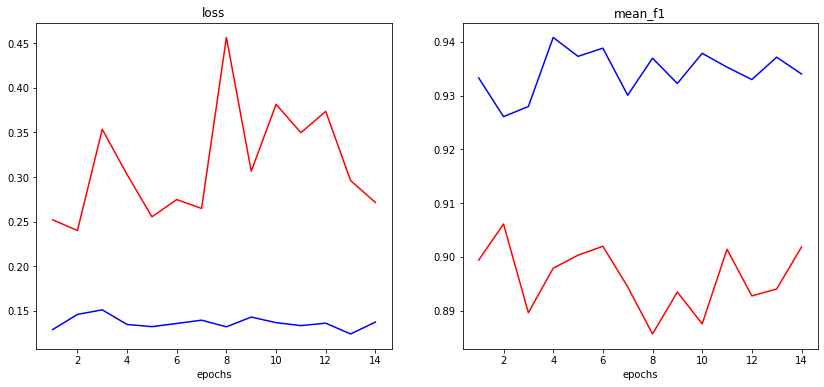

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("epochs")
plt.title("loss")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), f1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), f1_valid, color="r")
plt.xlabel("epochs")
plt.title("mean_f1")

plt.show()

In [ ]:
class TestDataset(Dataset):
    def __init__(self, path_test, transform, normalize = None):
        files = []
        for (dirpath, _, filenames) in os.walk(path_test):
          for f in filenames:
            if f.endswith('.jpg'):
              files.append([dirpath+'/'+f, f,])
        files = pd.DataFrame(files, columns = ['path','filename',])
        self.paths = files['path'].to_dict()
        self.filenames = files['filename'].to_dict()
        self.transform = transform
        self.normalize = normalize
    def __len__(self):
        return len(self.paths)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        path = self.paths[idx]
        file_name = self.filenames[idx]
        image = self.pil_loader(path)
        image = self.transform(image)
        if self.normalize:
            image = self.normalize(image)
        return image, file_name

In [ ]:
path_test = '/content/test/valid/'

test_transforms = val_transforms

batch_size = 32

test_dataset = TestDataset(path_test = path_test, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

test_dataloader:


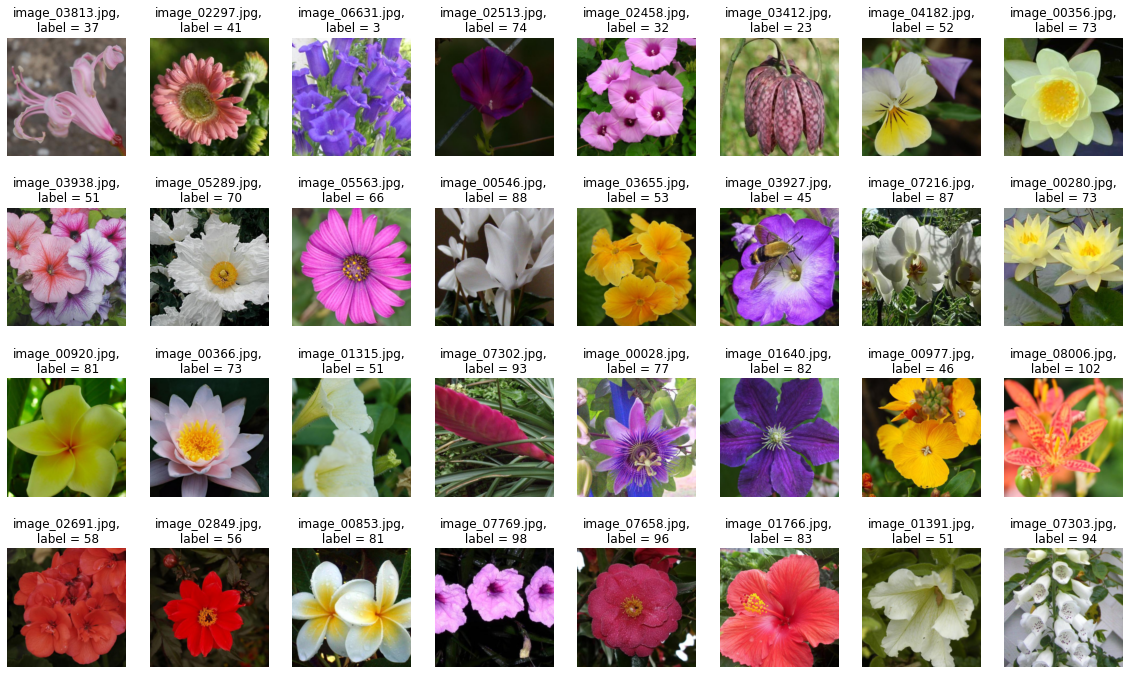

In [ ]:
def plot_examples(image, file_name, label):
  figure = plt.figure(figsize=(20, 12))
  cols, rows = 8, 4
  for i in range(0, cols * rows):

    figure.add_subplot(rows, cols, i+1)

    plt.title(f'{file_name[i]},\n label = {label[i].item() + 1}')
    plt.axis("off")
    plt.imshow(image[i].numpy().transpose([1,2,0]))
  plt.show()

print('test_dataloader:')
image, file_name = next(iter(test_dataloader))
image = image.to(device)

label = net(normalize(image))
label = label.argmax(1)
label = label.to('cpu').numpy()
image = image.to('cpu')
plot_examples(image, file_name, label)

In [ ]:
batch_size = 1
print(f'batch_size: {batch_size}')

test_dataset = TestDataset(path_test = path_test, transform=test_transforms, normalize = normalize)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

batch_size: 1


In [ ]:
Id_Category_map = {}

for i, (image, filename) in enumerate(tqdm(test_dataloader)):
  image = image.to(device)
  output = net(image)
  output = output.argmax(1).cpu().numpy()[0] + 1
  Id_Category_map[filename[0]] = output

  0%|          | 0/818 [00:00<?, ?it/s]

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission['Category'] = submission['Id'].map(Id_Category_map)

In [ ]:
submission.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,Id,Category
0,image_00028.jpg,77
1,image_00059.jpg,77
2,image_00061.jpg,77
3,image_00063.jpg,77
4,image_00071.jpg,77
...,...,...
813,image_08105.jpg,6
814,image_08113.jpg,93
815,image_08145.jpg,57
816,image_08155.jpg,84
